In [1]:
import numpy as np
from tqdm.notebook import tqdm

from plot import *
from maths import rmse


In [266]:
def _dft_at_time_level_and_latitude(data: np.ndarray, quantile: float = 0.75):
    fft = np.fft.rfft(data)
    amplitudes = np.abs(fft)

    cutoff_amp = np.quantile(amplitudes, quantile)
    fft_real = []
    fft_imag = []
    fft_indices = []

    for i, val in enumerate(fft[:256]):
        if amplitudes[i] < cutoff_amp:
            continue

        fft_real.append(fft[i].real)
        fft_imag.append(fft[i].imag)
        fft_indices.append(i)

    return np.array(fft_real, dtype="float16"), np.array(fft_imag, dtype="float16"), np.array(fft_indices, dtype="uint8")


def _idft_at_time_level_and_latitude(fft_real, fft_imag, fft_indices):
    fft = np.zeros((289,), dtype="complex64")

    k = 0
    for i in fft_indices:
        fft[i] = fft_real[k] + 1j * fft_imag[k]
        k += 1

    return np.fft.irfft(fft)



def plot_dft_at_time_level_and_latitude(filename: str, variable: str, time: int, level: int, latitude: int, folder: str,
                                        **kwargs):
    data = load_variable_at_time_level_and_latitude(filename, variable, time, level, latitude, folder)

    fft = _dft_at_time_level_and_latitude(data, **kwargs)
    prediction = _idft_at_time_level_and_latitude(*fft)

    plt.plot(np.linspace(-180, 180, 576), data, linewidth=1)
    plt.plot(np.linspace(-180, 180, 576), prediction, linestyle="dashed", linewidth=1)

    plt.title(f"{variable} ({get_units_from_variable(variable)}) at {format_latitude(latitude)}, {format_level(level)}"
              f" on {format_date(filename)} at {format_time(time)}", fontsize=8)
    plt.show()

    print(f"Original Standard Dev (m/s):  {data.std()}")
    print(f"Predicted Standard Dev (m/s): {rmse(data, prediction)}")


In [267]:
plot_dft_at_time_level_and_latitude("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U",
                                    time=0, level=71, latitude=180, folder="compressed/wind",
                                    quantile=0.965)

Original Standard Dev (m/s):  3.640625
Predicted Standard Dev (m/s): 1.036089797725573


[ 0  1  3  4  6  7  8 12 14 15 19]


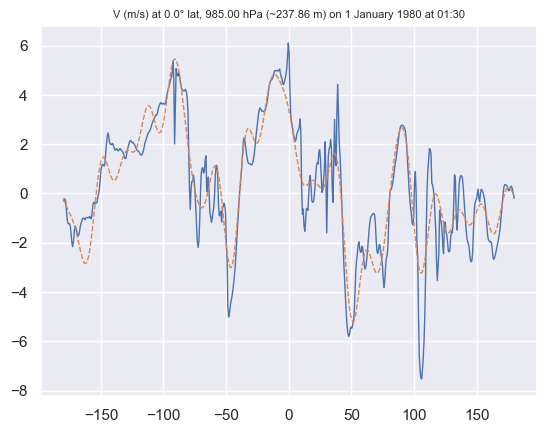

Frequencies: 11
Original Standard Dev (m/s):  2.53125
Predicted Standard Dev (m/s): 1.1106139116884193


In [254]:
plot_dft_at_time_level_and_latitude("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "V",
                                    time=0, level=71, latitude=180, folder="compressed/wind",
                                    quantile=0.965)

In [268]:
def plot_dft_at_time_and_level(filename: str, variable: str, time: int, level: int, folder: str, **kwargs):
    data = load_variable_at_time_and_level(filename, variable, time, level, folder)

    prediction = np.zeros((361, 576))

    worst_deviation = 0
    worst_lat = 0

    for lat in tqdm(range(361)):
        subdata = data[lat]

        fft = _dft_at_time_level_and_latitude(subdata, **kwargs)
        pred = _idft_at_time_level_and_latitude(*fft)

        if (dev := rmse(subdata, pred)) > worst_deviation:
            worst_deviation = dev
            worst_lat = lat

        prediction[lat] = pred

    _, ax1, ax2 = create_1x2_plot(f"{variable} ({get_units_from_variable(variable)}) at {format_level(level)}"
                                  f" on {format_date(filename)} at {format_time(time)}", sharey=True)
    ax1.imshow(data, cmap="viridis", origin="lower")
    ax2.imshow(prediction, cmap="viridis", origin="lower")

    _, ax1, ax2 = create_1x2_plot(f"Absolute Error ({get_units_from_variable(variable)}) at {format_level(level)}"
                                  f" on {format_date(filename)} at {format_time(time)}")
    ax1.imshow(np.abs(prediction - data), cmap="hot", origin="lower")
    ax2.plot(np.linspace(-180, 180, 576), data[worst_lat], linewidth=1)
    ax2.plot(np.linspace(-180, 180, 576), prediction[worst_lat], linestyle="dashed", linewidth=1)

    plt.show()

    print(f"Original Stdev: {data.astype('float32').std()} m/s")
    print(f"Predicted RMSE: {rmse(data, prediction)} m/s")
    print(f"Frequencies/latitude: {len(fft[0])}")
    print(f"Size/time: {len(fft[0]) * 361 * 5 * 72 / (1024 ** 2)} mB")
    print()
    print(f"Stdev at Worst: {data[worst_lat].astype('float32').std()} m/s")
    print(f"Worst RMSE: {worst_deviation} m/s")


In [269]:
%matplotlib notebook

plot_dft_at_time_and_level("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U",
                           time=0, level=71, folder="compressed/wind",
                           quantile=0.965)


  0%|          | 0/361 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Original Stdev: 5.884561061859131 m/s
Predicted RMSE: 1.709948194676284 m/s
Frequencies/latitude: 11
Size/time: 1.3633346557617188 mB

Stdev at Worst: 7.366096019744873 m/s
Worst RMSE: 2.956825750495654 m/s


In [265]:
%matplotlib notebook

plot_dft_at_time_and_level("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "V",
                           time=0, level=71, folder="compressed/wind",
                           quantile=0.965)

  0%|          | 0/361 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Original Stdev: 5.094567775726318 m/s
Predicted RMSE: 1.99678204402574 m/s
Frequencies/latitude: 11
Size/time: 1.3633346557617188 mB

Stdev at Worst: 6.0225830078125 m/s
Worst RMSE: 3.4011862128113157 m/s


In [270]:
def plot_dft_at_time(filename: str, variable: str, time: int, folder: str, **kwargs):
    data = load_variable_at_time(filename, variable, time, folder)
    prediction = np.zeros((72, 361, 576))

    worst_deviation_ratio = 0
    worst_deviation = 0
    worst_deviation_std = 0

    deviations = []

    for lev in tqdm(range(72)):
        for lat in range(361):
            subdata = data[lev][lat]

            fft = _dft_at_time_level_and_latitude(subdata, **kwargs)
            pred = _idft_at_time_level_and_latitude(*fft)

            if (ratio := (dev := rmse(subdata, pred)) / subdata.astype("float32").std()) > worst_deviation_ratio:
                worst_deviation_ratio = ratio
                worst_deviation = dev
                worst_deviation_std = subdata.astype("float32").std()

            deviations.append(dev)

            prediction[lev][lat] = pred

    plot_histogram([{"data": deviations}], "Distribution of Prediction RMSE (m/s)", bins=100)

    print(f"Original Stdev: {(data.astype('float32')).std()} m/s")
    print(f"Predicted RMSE: {rmse(data, prediction)} m/s")
    print(f"Size/time: {len(fft[0]) * 361 * 72 * 5 / (1024 ** 2)} mB")
    print()
    print(f"Stdev at Worst: {worst_deviation_std} m/s")
    print(f"Worst RMSE: {worst_deviation} m/s")


In [38]:
%matplotlib notebook

plot_dft_at_time("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U",
                 time=0, folder="compressed/wind",
                 quantile=0.965)

  0%|          | 0/72 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Original Stdev: 28.18543815612793 m/s
Predicted RMSE: 1.5336775651078645 m/s
Size: 1.090667724609375 mB

Stdev at Worst: 4.466701984405518 m/s
Worst RMSE: 2.6110967018071056 m/s


In [9]:
def compare_dft_at_time_vs_quantile(filename: str, variable: str, time: int, folder: str, quantiles: list[float], **kwargs):
    data = load_variable_at_time(filename, variable, time, folder)
    data_dict = []

    for quant in tqdm(quantiles):
        prediction = np.zeros((72, 361, 576))

        deviations = []

        for lev in range(72):
            for lat in range(361):
                subdata = data[lev][lat]

                fft = _dft_at_time_level_and_latitude(subdata, **kwargs)
                pred = _idft_at_time_level_and_latitude(*fft)

                deviations.append(rmse(subdata, pred))
                prediction[lev][lat] = pred

        data_dict.append({"data": deviations, "label": f"{quant * 100:0>1}%"})

    fig, ax11, ax12, ax21, ax22 = create_2x2_plot("Distribution of Prediction RMSE (m/s)", sharex=True, sharey=True)

    plt.sca(ax11)
    plot_histogram([data_dict[0]], "", bins=50)
    plt.sca(ax12)
    plot_histogram([data_dict[1]], "", bins=50)
    plt.sca(ax21)
    plot_histogram([data_dict[2]], "", bins=50)
    plt.sca(ax22)
    plot_histogram([data_dict[3]], "", bins=50)


In [ ]:
%matplotlib notebook

compare_dft_at_time_vs_quantile("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "U",
                                time=0, folder="compressed/wind",
                                quantiles=[0.95, 0.965, 0.975, 0.99])


In [ ]:
%matplotlib notebook

compare_dft_at_time_vs_quantile("MERRA2_100.tavg3_3d_asm_Nv.19800101.nc4", "V",
                                time=0, folder="compressed/wind",
                                quantiles=[0.95, 0.965, 0.975, 0.99])
